# SOCAT Cell Time Series
This notebook explores various aspects of the time series for grid cells in the SOCAT dataset.

Before running this notebook, you must run the following three scripts:
- `make_socat_database.jl` (needs a copy of the main SOCAT tsv file in the current directory)
- `make_timeseries_count.jl`
- `mean_sd_minute.jl`

These scripts create the database and netCDF files used by this notebook.

## Introduction

### Database Structure
`make_socat_database.jl` creates `socat.sqlite` which contains a simplified version of the SOCAT dataset. It contains one table (`socat`) with a record for each SOCAT observation. The table contains the following fields:

| Field         | Description                                                          |
|:--------------|:---------------------------------------------------------------------|
| `lonindex`    | The longitude cell index†                                            |
| `latindex`    | The latitude cell index†                                             |
| `year`        | The year in which the measurement was taken                          |
| `dayofyear`   | The day of the year on which the measurement was taken‡              |
| `minuteofday` | The minute of the day on which the measurement was taken             |
| `expocode`    | The Expo Code of the voyage during which the measurement was taken   |
| `sst`         | The measured sea surface temperature                                 |
| `sss`         | The measured sea surface salinity                                    |
| `fco2`        | The measured fCO₂                                                    |

†The index represents a 1° cell, ranging from `1 = 0.5°` through `360 = 359.5°` for longitude and `1 = -89.5°` to `180 = 89.5°` for latitude.

‡The `dayofyear` ignores leap years - dates on or after 29th February in leap years are decremented by 1 to align them with other years. This may lead to multiple time series for 28th February in a given year, but this shouldn't be a problem.

## Data Summary
`make_time_series_count.jl` and `mean_sd_minute.jl` compute statistics of the cells' time series. You can look at these in detail below, but for now here is a summary.

### Number of time series
The map below shows the number of days containing observations in each 1° grid cell, taken from the SOCATv2020 dataset.
![Time Series Count](time_series_count.png)

### Mean minute
This map shows the mean minute of the day in which observations wjere taken in each grid cell across the entire SOCAT dataset. The lack of a clear pattern indicates that there is no systematic bias across the dataset regarding observation time, which is expected.
![Mean Minute](mean_minute.png)

### R̅
The R̅ computed for a grid cell is a measure of how widely distributed the measurements are throughout the day. R̅ is a value between 0 and 1, where 0 indicates a wide distribution throughout the day and 1 indicating that measurements are concentrated around a particular time. The map below shows the R̅ for each grid cell.
![R̅](Rbar.png)

We would expect the cells with the most time series to have a greater distribution of measurements around the clock (R̅ close to zero) than those with few time series. However, this isn't the case:

In [58]:
%run notebook_module.ipynb

timeseriescount = Dataset("./time_series_count.nc")["count"][:,:].compressed()
R̅ = Dataset("./mean_sd_minute.nc")["minute_R̅"][:,:].compressed()

print(f'Time Series Count/R̅ correlation =  {np.corrcoef(timeseriescount, R̅)[0,1]}')

Time Series Count/R̅ correlation =  -0.16805433667306793


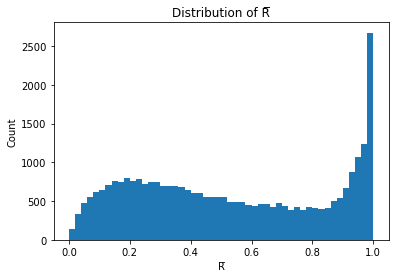

In [59]:
plt.hist(R̅, bins=50)
plt.xlabel('R̅')
plt.ylabel('Count')
plt.title('Distribution of R̅')
plt.show()

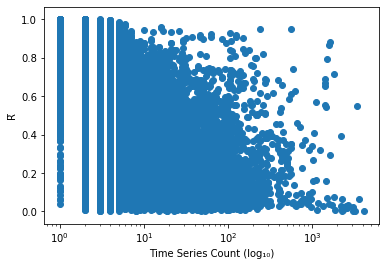

In [60]:
plt.scatter(timeseriescount, R̅)
plt.xscale('log')
plt.xlabel('Time Series Count (log₁₀)')
plt.ylabel('R̅')
plt.show()
#, label="", xlabel="Time Series Count (log₁₀)", ylabel="R̅", xscale=:log10)

## Cell Exploration
Below we can explore some details of specific grid cells. First up, a list of all the cells and their details. Below we build a table of all the cells.


In [ ]:
# Open the netCDF files and load the variables we want	
counts = Dataset("time_series_count.nc", "r")['count']
R̅s = Dataset("mean_sd_minute.nc", "r")["minute_R̅"]

cell_list = pd.DataFrame(columns=['Lon', 'Lat', 'TimeSeriesCount', 'R̅'])

for lon in log_progress(range(0,360), every=1, size=360, name='Calculating'):
    for lat in range(0,180):
        if counts[lat, lon] is not masked:
            cell_list = cell_list.append({"Lon":lon,"Lat":lat,"TimeSeriesCount":counts[lat, lon],"R̅":R̅s[lat, lon]}, ignore_index=True)

cell_list.sort_values(by=['TimeSeriesCount', 'R̅'], inplace=True)
cell_list
